In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from __future__ import print_function
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda, Input, Subtract, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import tensorflow as tf

import cv2
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [4]:
from keras.backend.tensorflow_backend import set_session
from utils import limited_gpu_memory_session
set_session(limited_gpu_memory_session(0.9))

In [5]:
DATA_DIR = '/home/Drive2/rishabh/'
TRAIN_FEATURES = os.path.join(DATA_DIR, 'features_train_omniglot.npy')
TEST_FEATURES = os.path.join(DATA_DIR, 'features_test_omniglot.npy')
INIT_WEIGHTS = os.path.join(DATA_DIR, 'init_weights_omniglot_triplet.hdf5')
CHECKPOINTED_WEIGHTS = os.path.join(DATA_DIR, 'checkpointed_weights_omniglot_triplet.hdf5')

In [6]:
from keras.preprocessing.image import ImageDataGenerator
image_width = 105
image_height = 105
image_size = (image_width, image_height)

datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = os.path.join(DATA_DIR, 'omniglot_keras/images_background') # python/

train_generator = datagen.flow_from_directory(
        train_dir,  target_size=image_size,
        batch_size = 19280,
        class_mode='sparse', color_mode="grayscale",
        shuffle=True)

test_dir = os.path.join(DATA_DIR, 'omniglot_keras/images_evaluation')

test_generator = datagen.flow_from_directory(
        test_dir,  target_size=image_size, # this is the target directory
        batch_size = 13180, color_mode="grayscale",
        class_mode='sparse')

Found 19280 images belonging to 964 classes.
Found 13180 images belonging to 659 classes.


In [7]:
import utils; reload(utils)
from utils import get_alphabet_to_index
test_alphabet_to_index = get_alphabet_to_index(test_generator)
train_alphabet_to_index = get_alphabet_to_index(train_generator)

In [8]:
X_train, y_train = train_generator.next()
X_val, y_val = test_generator.next()

In [9]:
def plot_data(X):
    counter = 0
    for img in X:
        plt.subplot(4, 5, counter+1)
        counter += 1
        plt.axis('off')
        plt.imshow(img[:,:,0], cmap = 'gray', interpolation="nearest")

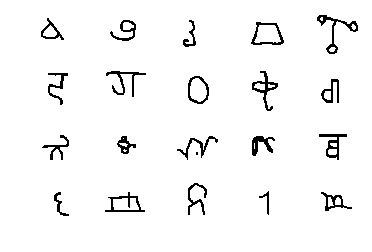

In [10]:
plot_data(X_val[:20])

# Build the convolutional neural network

In [11]:
from keras.regularizers import l2
from keras.models import load_model

MODEL_FILE = os.path.join(DATA_DIR, 'siamese_omniglot.h5')
siamese_net = load_model(MODEL_FILE)
for layer in siamese_net.layers:
    layer.trainable = False
siamese_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 105, 105, 1)   0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 105, 105, 1)   0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 4096)          38947648    input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
diff (Subtract)                  (None, 4096)          0           sequential_1[1][0]      

In [15]:
siamese_net.load_weights(os.path.join(DATA_DIR, 'checkpointed_weights_omniglot.hdf5'))

In [16]:
convnet = siamese_net.layers[2] #load_model(convnet_file)
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 256)         524544    
__________

In [20]:
from utils import get_available_gpus

def create_train_test_features(model, X_train, X_val):
    dev = get_available_gpus()
    
    # Train data
    print("Saving Train Features..")
    with tf.device(dev[0]):
        bottleneck_features_train = model.predict(X_train)
    # save the output as a Numpy array
    np.save(open(TRAIN_FEATURES, 'w'), bottleneck_features_train)
    
    # Test data
    print("Saving Test Features..")
    with tf.device(dev[-1]):
        bottleneck_features_test = model.predict(X_val)
    # save the output as a Numpy array
    np.save(open(TEST_FEATURES, 'w'), bottleneck_features_test)

if os.path.exists(TEST_FEATURES):
    create_train_test_features(convnet, X_train, X_val)

Saving Train Features..
Saving Test Features..


In [18]:
# train_data = conv
my_model = Model(inputs = convnet.inputs, outputs = convnet.get_layer('flatten_1').output)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 105, 105, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 128)         0         
__________

In [19]:
baseline_siamese_path = os.path.join(DATA_DIR, 'baseline_siamese_omniglot.h5')
if os.path.exists(baseline_siamese_path):
    INPUT_SHAPE = 4096
    inputs = [Input(shape=(INPUT_SHAPE,)) for _ in range(2)]
    diff = Subtract()(inputs)
    both = Lambda( lambda x: K.abs(x), lambda x : x)(diff)
    prediction = siamese_net.get_layer('output')(both)
    baseline_siamese = Model(inputs = inputs, outputs=prediction)
    baseline_siamese.summary()
    baseline_siamese.save(baseline_siamese_path)
else:
    baseline_siamese = load_model(baseline_siamese_path)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 4096)          0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 4096)          0                                            
____________________________________________________________________________________________________
subtract_1 (Subtract)            (None, 4096)          0           input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 4096)          0           subtract_1[0][0]        

In [46]:
w1 = baseline_siamese.get_weights() 
w2 = siamese_net.layers[-1].get_weights()
for a, b in zip(w1, w1):
    assert (a == b).all()

In [47]:
train_data = np.load(TRAIN_FEATURES)
test_data = np.load(TEST_FEATURES)

In [48]:
siamese_net.predict([X_val[:2], X_val[1:3]])

array([[ 0.41174769],
       [ 0.62274861]], dtype=float32)

In [49]:
baseline_siamese.predict([test_data[:2], test_data[1:3]])

array([[ 0.41174781],
       [ 0.62274885]], dtype=float32)

In [18]:
train_data = my_model.predict(X_train)
test_data = my_model.predict(X_val)

In [60]:
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2, l1
from keras.initializers import RandomNormal

INPUT_SHAPE = 4096
W_init = RandomNormal(mean=0, stddev=1e-2) #'glorot_uniform'
b_init = RandomNormal(mean= 0.5, stddev=1e-2)
def dense_relu_bn_dropout(x, size, dropout, alpha = 0.1, reg = 0):
    x = Dense(size, kernel_regularizer = l2(reg), kernel_initializer=W_init, bias_initializer=b_init)(x)
#     x = BatchNormalization()(x)
    x = Activation('selu')(x)
    x = Dropout(dropout)(x)
    return x

def create_network(reg, dropout, alpha = 0.1):
    inputs = Input(shape=(INPUT_SHAPE,))
    x = dense_relu_bn_dropout(inputs, 4096, dropout, reg)
    x = dense_relu_bn_dropout(x, 4096, dropout, reg)
    x = dense_relu_bn_dropout(x, 2048, dropout, reg)
    base_network = Model(inputs=inputs, outputs = x)
    print(base_network.summary())
    return base_network

In [61]:
base_network = create_network(1e-3, 0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_4 (Activation)    (None, 4096)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_5 (Activation)    (None, 4096)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4096)              0         
__________

In [62]:
def l2_norm(x):
    return K.sqrt(K.sum(K.square(x)))

In [81]:
input_pair = [Input((INPUT_SHAPE,)) for _ in range(2)]
outputs_base = [base_network(inp) for inp in input_pair]
diff = Subtract()(outputs_base)
euclidean_dist = Lambda(l2_norm, output_shape = lambda x : (x[0], 1))(diff)
model = Model(inputs = input_pair, outputs = euclidean_dist)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_19 (InputLayer)            (None, 4096)          0                                            
____________________________________________________________________________________________________
input_20 (InputLayer)            (None, 4096)          0                                            
____________________________________________________________________________________________________
model_6 (Model)                  (None, 2048)          41953280    input_19[0][0]                   
                                                                   input_20[0][0]                   
____________________________________________________________________________________________________
subtract_6 (Subtract)            (None, 2048)          0           model_6[3][0]           

In [64]:
model = baseline_siamese

In [71]:
test_alphabet_to_index['Angelic']

[18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 7, 8, 3, 4, 5, 6, 0, 1, 2, 19]

#### Define the  triplet loss

In [82]:
MARGIN = 0.1
def triplet_loss(y_true, y_pred): # 
    return K.mean(K.maximum(0.0, y_pred + MARGIN) - y_true * 0, axis = -1)

#### Define the  triplet network

In [83]:
## Define the triplet network
from keras.layers import Average
input_triples = [Input((INPUT_SHAPE,)) for _ in range(3)]
pos_output = model(input_triples[:-1])
neg_output0 = model(input_triples[1:]) 
neg_output1 = model([input_triples[0], input_triples[2]])
neg_output = Average()([neg_output0, neg_output1])
diff = Subtract()([neg_output, pos_output])
triplet_net = Model(inputs = input_triples, outputs = diff)
triplet_net.summary()
triplet_net.save_weights(INIT_WEIGHTS)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_22 (InputLayer)            (None, 4096)          0                                            
____________________________________________________________________________________________________
input_23 (InputLayer)            (None, 4096)          0                                            
____________________________________________________________________________________________________
input_21 (InputLayer)            (None, 4096)          0                                            
____________________________________________________________________________________________________
model_10 (Model)                 (None, 1)             41953280    input_21[0][0]                   
                                                                   input_22[0][0]          

#### Create the data generator to load batches of data

In [76]:
import utils; reload(utils)
from utils import TripletGenerator

NUM_TRAIN_TRIPLETS = 300000
NUM_VAL_TRIPLETS = 10000
BATCH_SIZE = 128
datagen = TripletGenerator(train_data, y_train, test_data, y_val, num_val_triplets=NUM_VAL_TRIPLETS, 
                           batch_sz=BATCH_SIZE, num_train_triplets=NUM_TRAIN_TRIPLETS, 
                           train_alphabet_to_index = train_alphabet_to_index,
                           test_alphabet_to_index = test_alphabet_to_index)

In [77]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
              patience=3, verbose = 1, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=1e-4,
                              patience=25,
                              verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath=CHECKPOINTED_WEIGHTS, verbose=1, save_best_only=True, monitor='val_loss')

In [28]:
STEPS_PER_EPOCH = NUM_TRAIN_TRIPLETS//BATCH_SIZE
VALIDATION_STEPS = NUM_VAL_TRIPLETS//BATCH_SIZE 

In [88]:
from keras.optimizers import Adam
adam = Adam(1e-7)
triplet_net.compile(loss=triplet_loss, optimizer=adam, metrics=['accuracy'])
triplet_net.load_weights(INIT_WEIGHTS)

In [89]:
# triplet_net.load_weights(CHECKPOINTED_WEIGHTS)
history = triplet_net.fit_generator(
        datagen.next_train(),
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=500,
        validation_data=datagen.next_val(),
        validation_steps=VALIDATION_STEPS,
        callbacks = [reduce_lr, checkpointer, early_stopping])

Epoch 1/500
1111/2343 [=============>................] - ETA: 39s - loss: 0.6654 - acc: 0.2250

KeyboardInterrupt: 

In [ ]:
triplet_net.load_weights(CHECKPOINTED_WEIGHTS)

In [80]:
# triplet_net.load_weights(CHECKPOINTED_WEIGHTS)
history = triplet_net.evaluate_generator(
        datagen.next_train(),
        steps=STEPS_PER_EPOCH)
print(history)

[0.12911167513774696, 0.0017472257789159199]
